<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/8_KNN_Naive_Bayes_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 🚀 KNN
- 값을 예측하고자하는 데이터와 유사한 피처 값을 가지는 k개의 이웃 데이터를 찾는다. 유사한 데이터들이 다수가 속한 클래스로 값을 예측하거나 (분류), 데이터들의 평균값을 계산하여 (회귀) 예측값을 구함

- 모든 예측 변수들이 수치형, 특징의 척도, 거리 계산 방법, K개의 개수에 따라 예측 결과가 달라짐

##### [거리 지표 설정]
- 유클리드 거리 : 두 점 사이의 직선 거리  
- 맨해튼 거리: 직각 방향의 거리
- weights
            uniform - 동일한 가중치로 데이터 거리 계산
            distance - 거리가 가까운 이웃일 수록 가중치 부여

 ##### [K 선택하기]        
 - 보통 1~20 사이의 홀수로 모델링하며 성능 비교

      ![KNN Algorithm]( https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSOonlBW6TYrLiZmrDlCq0ubjxyYUbuVmcD5w&s)

### K-Nearest Neighbors (KNN) Algorithm: Pros & Cons

      1) 분류 혹은 분류 3개 이상의 목표일때,
      2) 작은 데이터 세트에 적합

| 장점 (Advantages) | 단점 (Disadvantages) |
|------------------|------------------|
| 구현이 간단하고 이해하기 쉬움 | 계산 비용이 높아 데이터셋이 클 경우 성능 저하 (O(n)) |
| 사전 학습(Training)이 필요 없음 (Lazy Learning) | 차원의 저주(Curse of Dimensionality)에 취약 |
| 다양한 거리(metric) 기반으로 적용 가능 | 이상치(Outlier)에 민감함 |
| 새로운 데이터에 대한 예측이 직관적 | 데이터가 많아질수록 메모리 사용량 증가 |
| 데이터 분포가 명확한 경우 강력한 성능을 발휘 | 범주 불균형(Class Imbalance)이 있을 경우 성능 저하 가능 |





In [51]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/wine.csv'
data = pd.read_csv(file_url)
df = data.copy()

In [52]:
print(df.describe())
print("""
변수마다 단위의 문제가 있다. 변수의 스케일이 다른것이 거리 기반 알고리즘인 KNN에 문제가 될 수 있기 때문에 스케일링이
필요해보인다. 또 한, 몇몇 변수에서 75%와 max의 차이가 큰데, 이는 아웃라이어로 예상되며, 경우에 따라 이상치가
모델링에 영향을미칠 수 있다.
""")

          alcohol  malic_acid         ash  alcalinity_of_ash   magnesium  \
count  176.000000  178.000000  178.000000         178.000000  178.000000   
mean    12.989091    2.336348    2.366517          19.494944   99.741573   
std      0.804431    1.117146    0.274344           3.339564   14.282484   
min     11.030000    0.740000    1.360000          10.600000   70.000000   
25%     12.355000    1.602500    2.210000          17.200000   88.000000   
50%     13.050000    1.865000    2.360000          19.500000   98.000000   
75%     13.672500    3.082500    2.557500          21.500000  107.000000   
max     14.750000    5.800000    3.230000          30.000000  162.000000   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count     178.000000  178.000000            173.000000       178.000000   
mean        2.295112    2.029270              0.362370         1.590899   
std         0.625851    0.998859              0.126153         0.572359   
min         0.9

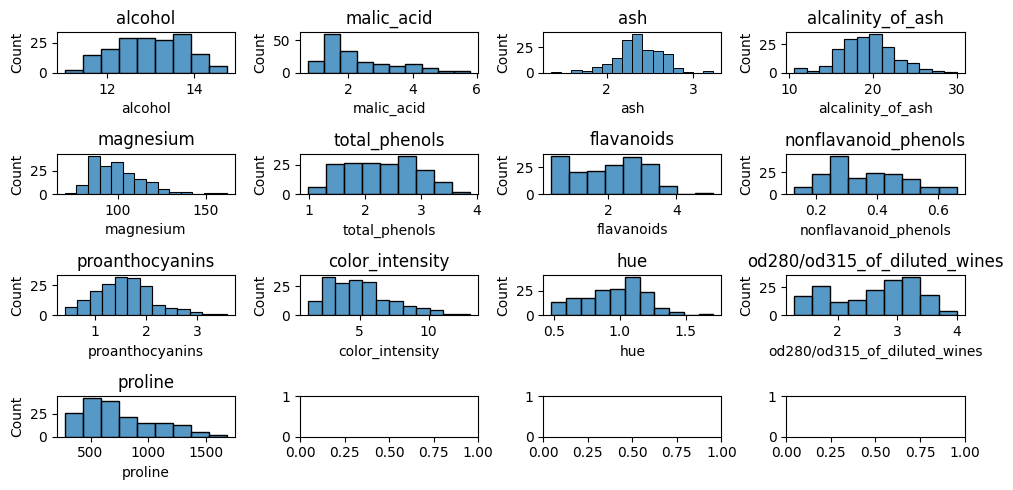


alcohol, asbh, total_phenols 은 대략적으로 정규 분포를 띄고 있으나, 
malic_acid, magesum, color_intensity, proline 등의 변수는 한쪽으로 치우친 분포를 포인다. 




In [53]:
# EDA
fig, axes = plt.subplots(4,4, figsize = (10, 5))

for i, ax in enumerate(axes.flat[:len(df.drop(columns = 'class', axis = 1).columns)]) :
  col_i = df.columns[i]
  sns.histplot(df[col_i], ax = ax)
  ax.set_title(col_i)

plt.tight_layout()
plt.show()

print("""
alcohol, asbh, total_phenols 은 대략적으로 정규 분포를 띄고 있으나,
malic_acid, magesum, color_intensity, proline 등의 변수는 한쪽으로 치우친 분포를 포인다.

""")

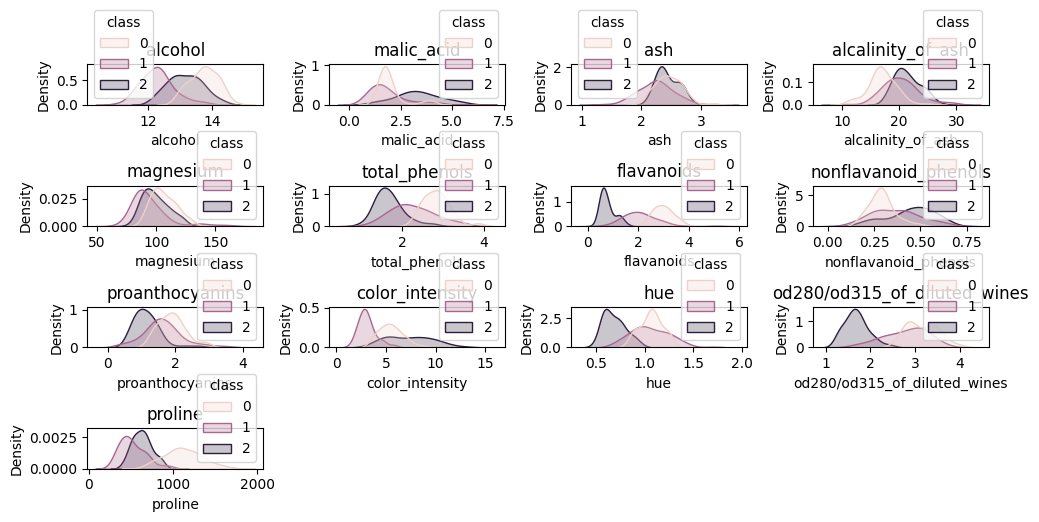

In [54]:
# Class별 분포도

feature_cols = df.drop(columns = 'class', axis = 1).columns
target_col = 'class'

fig, axes = plt.subplots(4,4 , figsize = (10,5))
for i , col in enumerate(feature_cols) :
  sns.kdeplot(data=  df, x=col,   hue=df[target_col], fill=True, common_norm=False, ax=axes.flat[i])
  axes.flat[i].set_title(col)

# 불필요한 빈 그래프 제거 (전체 feature 개수가 16개보다 적을 경우)
for j in range(i + 1, 16):  # 16개의 서브플롯 생성했으므로, 사용되지 않은 부분 숨기기
    fig.delaxes(axes.flat[j])

# 레이아웃 조정
plt.tight_layout()
plt.show()

### 📌 결측치 처리 방법 및 활용 시점

| **방법** | **설명** | **활용 시점** |
|------|------|----------|
| **1. 제거(Dropping)** | 결측치가 포함된 행 또는 열을 삭제 | - 결측치 개수가 적고, 데이터 손실이 크지 않을 때 <br> <br> - 분석에 필수적인 데이터가 없는 경우 |
| **2. 평균/중앙값/최빈값 대체(Imputation)** | - 수치형 변수 → 평균(Mean) 또는 중앙값(Median)으로 대체 <br><br>  - 범주형 변수 → 최빈값(Mode)으로 대체 | - 결측치 개수가 적당하고, 데이터의 분포를 크게 왜곡하지 않을 때 |
| **3. 예측 모델 기반 대체(Predictive Imputation)** | 회귀분석, KNN, 랜덤 포레스트 등을 사용하여 결측값 예측 | - 결측치가 많고, 데이터 패턴을 활용해 대체할 수 있을 때 |
| **4. KNN(최근접 이웃) 대체** | K개의 이웃 데이터를 활용하여 평균값을 사용해 대체 | - 유사한 패턴을 가진 데이터가 많을 때 <br><br>  - 데이터의 분포를 최대한 유지하고 싶을 때 |
| **5. 다중 대체법 (Multiple Imputation)** | 결측값을 여러 번 샘플링하여 대체하는 기법 | - 결측값이 많고, 신뢰성 있는 대체 방법이 필요할 때 <br><br>  - 데이터가 특정한 패턴을 따르지 않는 경우 |
| **6. 비즈니스 로직 기반 대체** | 도메인 지식을 활용하여 특정 값으로 대체 | - 해당 변수의 특성을 잘 알고 있는 경우 <br><br>  - 비즈니스 규칙에 따라 특정 값을 채우는 것이 합리적일 때 |

---

📌 **결론:**  
- 단순한 결측치 문제라면 **평균/중앙값 대체**를 사용  
- 패턴이 있는 데이터라면 **KNN 또는 머신러닝 기반 대체** 적용  
- 결측치가 많고 신뢰도 높은 대체가 필요하다면 **다중 대체법(MICE)** 고려  
- 분석 목적과 데이터 특성을 고려하여 적절한 방법을 선택해야 함! 🚀


In [55]:
## 결측치 처리 방식 선택하기
# 평균 = 실제값과 일치할 가능성이 매우 낮기 때문에 오차의 원인이 될 수 있음 - 노이즈가 더해진 효과를 낸다.
# dropna = 결측치를 상제 하려면 비중이 매우 낮아야 하고, 데이터 크기도 충분히 커야함
# 통상적으로 50%이상이면 drop()을 고려해볼만 하고, 70~80%이면 drop적용하는것이 좋다.

# 해당 데이터는 결측치를 채우되, 아웃아이러에 조금 덜 민감한 중의값을 사용
df.fillna(df.median(), inplace = True)

### 📌 Scaling

        1. 표준화 : 평균 0, 표준편차 1로 고르게 분포시킴
                    기존 분포 형태가 사라지고, 정규분포를 따르는 결과
        2. MIN/MAX : 데이터의 분포의 특성을 최대한 그대로 사용하고 싶을 때, 최대 1, 최소 0
                    기존의 분포를 있는 대로 담아내며 스케일만 변화
        3. 로버스트 : 아웃라이어가 존재하고, 그 영향력을 그대로 유지하고 싶을 때, 사분위값을 이용하여 계산
                      변화된 데이터의 범위는 표준화 스케일링이나,
                      최대-최소 스케일링 보다 넓게 나타남
        4. 정규화 : 행 기준의 스케일링이 필요할때, 실제 거의 사용하지 않음

In [56]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

mm = MinMaxScaler()

X = df.drop(columns = 'class', axis = 1)
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 100)

# X_train 학습
mm.fit(X_train)

# transform
X_train_scaled = mm.fit_transform(X_train)
X_test_scaled = mm.transform(X_test)


from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
pred = knn.predict(X_test_scaled)

print(accuracy_score(y_test , pred))

0.9444444444444444


### 📌 최적의 K 찾기


13 이후로 더 나은 개선을 보이지 않기 때문에, n_neighbors를 13으로 지정한다. 



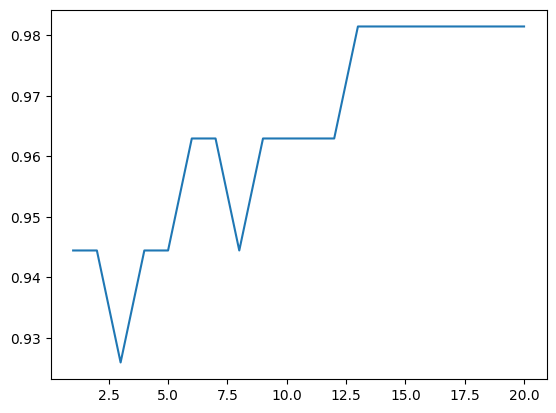

In [57]:

res = []
for i in range(1,21) :
  knn = KNeighborsClassifier(n_neighbors= i)
  knn.fit(X_train_scaled, y_train)
  pred = knn.predict(X_test_scaled)
  score = accuracy_score(y_test , pred)
  res.append(score)



# 그래프로
sns.lineplot(x = range(1, 21), y= res)
print("""
13 이후로 더 나은 개선을 보이지 않기 때문에, n_neighbors를 13으로 지정한다.
""")

#### 🚀 Naive Bayes

        1) 조건부 확률 기반의 분류 모델 - 스펨메일
          장점 : 간단한 알고리즘 이며, 빠른 속도, 작은 세트도 잘 예측
          단점 : 모든 변수가 독립임을 전제로 하는데, 실제 데이터에서 그런 경우가 많지 않기 때문에 단점
          활용 : 범주 형태의 변수가 많을때, 숫자형 변수에는 적합하지 않음

        2) 훈련 데이터가 각 예측 변수가 나타날 조건부 확률과 각 클래스의 사전 확률을 계산하여, 각 클래스에 대한 조건부 확률과 사후 확률을 계산, 가장 높은 사후 확률을 가지는 클래스로 분류

        3) scikit-learn 에서의 분류기
        - Gaussian NB : y가 연속형일때, 우도가 가우시안 분포를 따른다는 가정
        - BernolliNB : y가 Binary 일때
        - MultinomialNB : y가 빈도 데이터 일때
        - CategoricalNB : y가 Categorical 분포를 따를때
        - CompletementNB : MultinomialNB 알고리즘을 개선, 불균형 데이터 셋에서 잘 동작

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

file_url = 'https://media.githubusercontent.com/media/musthave-ML10/data_source/main/spam.csv'
data = pd.read_csv(file_url)
df = data.copy()
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [78]:
import string

def remove_punc(x) :
  lst =[]
  for i in x :
    if i not in string.punctuation :
      lst.append(i)
  lst =  ''.join(lst)
  return lst

# apply함수로 한 출씩 적용
df['text'] = df['text'].apply(remove_punc)

# 불용어 제거
import nltk
nltk.download('stopwords')

def stop_words(x) :
  new_lst = []
  for i in x.split() :
    if i.lower() not in stopwords.words('english'):
      new_lst.append(i.lower())
  new_list = ' '.join(new_lst)
  return new_list


df['text'] = df['text'].apply(stop_words)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,text
0,ham,go jurong point crazy available bugis n great ...
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 2...
3,ham,u dun say early hor u c already say
4,ham,nah dont think goes usf lives around though


In [79]:
# Target 변환
df['target'] = df['target'].map({'spam': 1, 'ham' : 0})


In [81]:
# 카운트 기반으로 백터화 하기
x = df['text']
y = df['target']

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
cv.fit(x)
cv.vocabulary # 단어와 인텍스
x = cv.transform(x)
print(x[1])

print("""

(0. 4655) 1
0번째 데이터 row에서, index가 4655인 단어가 한번 등장한다.
""")


  (0, 4655)	1
  (0, 4886)	1
  (0, 5995)	1
  (0, 6027)	1
  (0, 9079)	1


(0. 4655) 1 
0번째 데이터 row에서, index가 4655인 단어가 한번 등장한다. 



[[965  12]
 [  4 134]]


<Axes: >

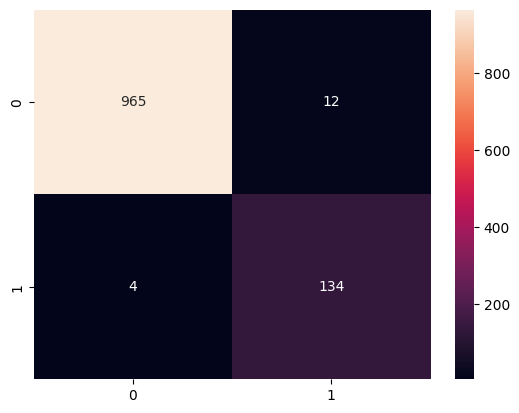

In [82]:

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 100)


from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
model = MultinomialNB()
model.fit(x_train, y_train)
pred = model.predict(x_test)
print(confusion_matrix(y_test, pred))

sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='.0f')

#### 🚀 SVM
  ✅ 이진 클래스로 분류되는 데이터를 학습하여, 클래스가 어디에 속할지를  판단하는 "비확률적 이진 선형 분류 모델"을 만들어, 이진 클래스를 구분하는 결정 경계들 중, 어떠한 데이터도 포함하지 않는 경계(마진, Margin)을 찾아, 이 결정 경계가 가장 가까이 있는 일부 훈련 데이터를 Support Vector라고 한다.

  ✅ 비선형 분류 : 커널 기법 (다항식, 가우시안)의 커널 기법을 사용하여, 비선형적 특성을 추가한다.

  ✅ 초명편- 데이터를 구분하는 결정 경계 (Decision Boundary)

          2 차원 : 선
          3 차원 : 평면
          4 차원 : 초평면 : 초평면을 통해 데이터가 2개의 클래스로 나위며, SVM은 이 초평면을 최적의 위치에 배치

  4) 마진
    - 마진을 최대화하면서 데이터 포인트를 정화학게 분류하는 최적의 초평면을 찾는다.
    - 마진이 클수록 성능이 좋아짐으로, 마진이 최대화된 결정 경계를 찾는것이 중요

    💡 C 값(Regularization Parameter)

        C 값이 크면: 마진이 작아지고, 데이터 분류를 더 엄격하게 수행 (하드 마진에 가까워짐).
        C 값이 작으면: 마진이 커지고, 일부 데이터가 초평면을 넘어도 허용 (소프트 마진).

커널 트릭(Kernel Trick)
SVM은 기본적으로 선형 분류를 수행하지만, 비선형 데이터(복잡한 형태의 데이터)를 분류할 때 **커널 트릭(Kernel Trick)**을 활용할 수 있다.

✅ 커널 트릭이란?

        저차원의 데이터를 고차원 공간으로 변환하여 선형적으로 분리 가능하게 만드는 기법.
        원래 공간에서는 선형 분리가 어렵지만, 고차원으로 매핑하면 초평면을 통해 쉽게 분류할 수 있음.
✅ 주요 커널 종류

        선형 커널 (Linear Kernel):선형적으로 분리 가능한 경우 사용 텍스트 분류, 선형 데이터
        다항식 커널 (Polynomial Kernel):다항식 특성을 추가하여 비선형 데이터를 분류곡선 형태의 경계선이 필요한 데이터
        RBF 커널 (Radial Basis Function Kernel):가우시안 분포를 기반으로 데이터의 유사성을 계산복잡한 패턴이 있는 비선형 데이터         
        시그모이드 커널 (Sigmoid Kernel): 뉴럴 네트워크 활성화 함수와 유사신경망과 비슷한 특징을 가진 데이터


 ✅ 장/단점

          장점 : 데이터가 적더라도, 복잡한 결정 경계를 만들 수 있으며,
                 저차원, 고차원 데이터에 모두 잘 작동
          단점 : 대용량 데이터에 잘 작동하지 않고,
                 스케일링, 데이터 전처리, 매개변수 설정이 중요.

In [84]:
#!pip install ISLP

In [85]:
import numpy as np
from matplotlib.pyplot import subplots, cm
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table

from sklearn.svm import SVC
from ISLP.svm import plot as plot_svm
from sklearn.metrics import RocCurveDisplay

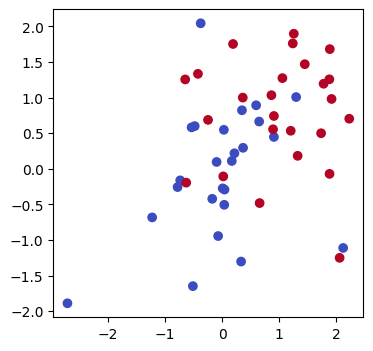

In [87]:
rng = np.random.default_rng(1)
X = rng.standard_normal((50, 2))
y = np.array([-1]*25+[1]*25)
X[y==1] += 1
fig, ax = subplots(figsize=(4,4))
ax.scatter(X[:,0],
           X[:,1],
           c=y,
           cmap=cm.coolwarm);

print("""
아래의 데이터에서 두 분류에 속하는 것을 선형적으로 분리가 가능하지 않다.
""")

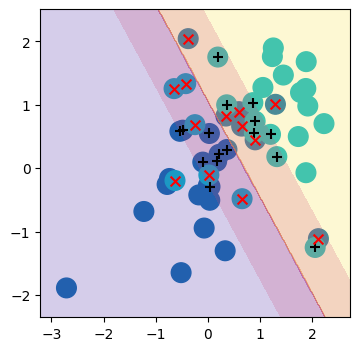

In [90]:
svm_linear = SVC(C = 10, kernel = 'linear')
svm_linear.fit(X, y)
fig, ax = subplots(figsize = (4,4))
plot_svm(X, y, svm_linear, ax = ax)

print("""
kernel = linear 인자를 사용해서 선형 분리를 하여, 서포트 벡터는 +로 나타내며, 관측은 원으로 표시된다.
""")

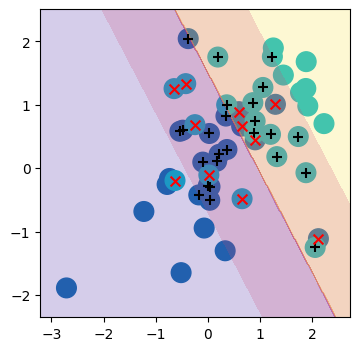

In [91]:
svm_linear = SVC(C = 0.1, kernel = 'linear')
svm_linear.fit(X, y)
fig, ax = subplots(figsize = (4,4))
plot_svm(X, y, svm_linear, ax = ax)
# 마진이 더 넓어져서 더 많은 서포트 벡터을 얻을 수 있다.

In [92]:
# Best Param with KFOld

kfold = skm.KFold(5, random_state =0, shuffle = True)

grid = skm.GridSearchCV(svm_linear,
                        {'C':[0.001,0.01,0.1,1,5,10,100]},
                        refit=True,
                        cv=kfold,
                        scoring='accuracy')

grid.fit(X, y)
grid.best_params_

{'C': 1}

In [137]:
# 문제) 연비가 높은지 낮은지 예측하기 위해 SVM 을 쓴다
df = pd.read_csv('https://raw.githubusercontent.com/ogulcancicek/An-Introduction-to-Statistical-Learning-Python/refs/heads/main/data/Auto.csv')

# subset : horsepower 열만 대상으로결측치 검사
#df.dropna(subset= ['horsepower'], inplace = True)
df.dropna(inplace = True)
df = df[df['horsepower'] != '?']

valid_indices = [i for i in [32,330,336, 354] if i in df.index]
df.loc[valid_indices]

# 1) 연비가 중앙값을 초과하면 1, 이하는 0인 이진변수 생성
median_value = df['mpg'].median()
df['var']= df['mpg'].apply(lambda x : 1 if x > median_value else 0)


X = df.drop(columns = ['var','mpg','name'], axis = 1)
y = df['var']

In [138]:
# 2) 다양한 C값으로 SVM에 적합해 자동차의 연비가 높고 낮은지 예측하라. 다양한 값에 따른 교차 검증 오류를 보고
from sklearn.model_selection import GridSearchCV

params = {'C' : 10 ** np.linspace(-2,3,6)}

svc = SVC(kernel = 'linear')
tune = GridSearchCV(svc, params, cv = 5)
tune.fit(X,y)

res1 = pd.DataFrame(tune.cv_results_).loc[:,  ['param_C', 'mean_test_score', 'std_test_score']]
res1.sort_values(by = 'mean_test_score', ascending = False)

print("""
mean_test_scor가 가장 높은 C값을 찾는다. std_test_score도 고려하여, mean_test_score가 조금 낮더라도
std_test_score가 낮은 C값을 선택한다. 최적의 param_C 은 0.01
""")


mean_test_scor가 가장 높은 C값을 찾는다. std_test_score도 고려하여, mean_test_score가 조금 낮더라도 
std_test_score가 낮은 C값을 선택한다. 최적의 param_C 은 0.01 



    param_C  param_gamma  mean_test_score  std_test_score
15     10.0          0.5         0.510256        0.028553
20    100.0          0.5         0.510256        0.028553
10      1.0          0.5         0.510256        0.028553
25   1000.0          0.5         0.510256        0.028553
21    100.0          1.0         0.502564        0.022790
11      1.0          1.0         0.502564        0.022790
16     10.0          1.0         0.502564        0.022790
26   1000.0          1.0         0.502564        0.022790
17     10.0          2.0         0.494872        0.010256
27   1000.0          2.0         0.494872        0.010256


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


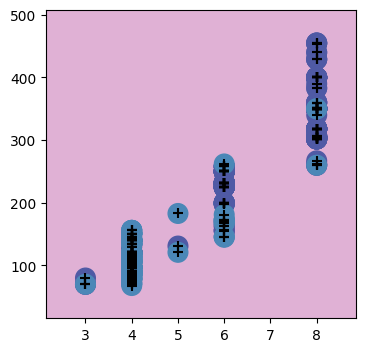

In [148]:
# 다양한 gamma, degree, C값을 사용해 방상형 및 다항 기저 커너을 사용하는 SVM으로 반복하라.

params = {'C': 10**np.linspace(-2, 3, 6),
         'gamma': [0.5, 1, 2, 3, 4]}

svm = SVC(kernel='rbf')
tune2 = GridSearchCV(svm, params, cv=10)
tune2.fit(X, y)
print(
pd.DataFrame(tune2.cv_results_).loc[:, ['param_C', 'param_gamma', 'mean_test_score', 'std_test_score']].sort_values(by = 'mean_test_score', ascending = False).head(10))



svm_rbf = SVC(C = 10.0 , gamma = 0.5,kernel='rbf')
svm_rbf.fit(X,y)
fig, ax = plt.subplots(figsize=(4, 4))
plot_svm(X, y, svm_rbf, ax = ax)
plt.show()

# 배경 색상이 단일 색으로 결정 경계가 보이지 않음, 하나의 클래스로 모든 데이터를 분류할 가능성 존재
# + 만 존재하고 결정 경계인 x가없음
# 원인) C값 재확인, 잘못된 커널, 데이터 전처리 문제 (스케일링)

In [140]:
# SVM with polynomial kernel - poly kernel이 가장 높은 분류 모형

params = {'C': 10**np.linspace(-2, 3, 6),
         'degree': [1, 2, 3, 4, 5, 6]}

svm = SVC(kernel='poly')
tune3 = GridSearchCV(svm, params, cv=10)
tune3.fit(X, y)

pd.DataFrame(tune3.cv_results_).loc[:, ['param_C', 'param_degree',
                                        'mean_test_score', 'std_test_score']].sort_values(by = 'mean_test_score', ascending = False).head(10)



,param_C,param_degree,mean_test_score,std_test_score
32,1000.0,3,0.902885,0.039481
31,1000.0,2,0.902821,0.052278
25,100.0,2,0.900385,0.042195
30,1000.0,1,0.900256,0.046501
27,100.0,4,0.897885,0.041474
33,1000.0,4,0.897821,0.046018
26,100.0,3,0.897821,0.041512
34,1000.0,5,0.892756,0.047025
28,100.0,5,0.890321,0.042910
35,1000.0,6,0.890256,0.039918


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


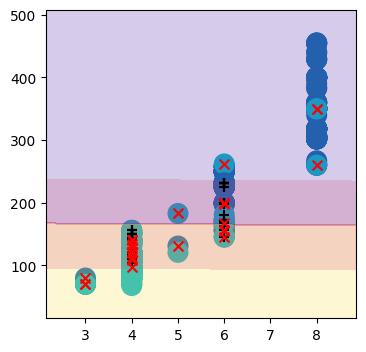

In [143]:
X = X.reset_index(drop = True).astype(float)
y = y.reset_index(drop = True).astype(int)

# 최적의 하이퍼파라미터를 반영한 모델
svm_poly = SVC(C=1000.0, degree = 3,  kernel='poly')  # C 값이 float인지 확인
svm_poly.fit(X, y)

# 시각화
fig, ax = plt.subplots(figsize=(4, 4))
plot_svm(X, y, svm_poly, ax=ax)
plt.show()